In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging, pickle, copy
logging.basicConfig(filename='./_logs/exp-1-simulations.log',level=logging.DEBUG)
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns

from pyrlap.domains.gridworld import GridWorld
from demoteaching.mdps.discretizedobmdp import DiscretizedObserverBeliefMDPApproximation
from demoteaching.mdps.obs_belief_mdp import ObserverBeliefMDP

In [3]:
#=============================#
#   Build set of ground MDPs  #
#=============================#
danger_r = -2
goal_reward = 10
init_ground = (0, 2)
goal_s = (5, 2)

do_temp = .05
do_randchoose = .05
do_discount = .95
show_temp = .05
show_randchoose = .05
show_discount = .95
show_reward = 10
n_trajs = 1000

n_bins = 1
seed_trajs = []
np.random.seed(4234)

mdp_params = []
feature_rewards = []
for rs in product([0, danger_r], repeat=3):
    feature_rewards.append(dict(zip('opc', rs)))

mdp_codes = []
for fr in feature_rewards:
    rfc = ['o' if fr[f] == 0 else 'x' for f in 'opc']
    rfc = ''.join(rfc)
    mdp_codes.append(rfc)
    fr['y'] = goal_reward
    fr['.'] = 0

planners = {}
for mdpc, frewards in zip(mdp_codes, feature_rewards):
    params = {
        'gridworld_array': ['.oooo.',
                            '.oppp.',
                            '.opccy',
                            '.oppc.',
                            '.cccc.'],
        'feature_rewards': frewards,
        'absorbing_states': [goal_s, ],
        'init_state': init_ground,
        'wall_action': False,
        'step_cost': 0,
        'wait_action': False,
        'include_intermediate_terminal': True
    }
    mdp = GridWorld(**params)
    planner = mdp.solve(
        softmax_temp=do_temp, 
        randchoose=do_randchoose, 
        discount_rate=do_discount)
    seed_trajs.extend([planner.run() for _ in range(100)])
    planners[mdpc] = planner

#===========================================#
#   Build Observer Belief MDP and support   #
#===========================================#
obplanners = {}
discretized_tf = None
for true_mdp_code in mdp_codes:
    obmdp = DiscretizedObserverBeliefMDPApproximation(
        n_probability_bins=n_bins,
        seed_trajs=seed_trajs,
        branch_steps=0,
        discretized_tf=discretized_tf,
        planners=planners,
        true_planner_name=true_mdp_code,
        belief_reward_type='true_gain',
        only_belief_reward=False,
        belief_reward=show_reward,
        update_includes_intention=True
    )
    discretized_tf = obmdp.get_discretized_tf()
    obplanner = obmdp.solve(
        softmax_temp=show_temp,
        randchoose=show_randchoose,
        discount_rate=show_discount
    )
    obplanners[true_mdp_code] = obplanner

In [4]:
# Basic Second-order reasoning MDP
ob2_mdp = ObserverBeliefMDP(
    planners=obplanners,
    true_planner_name=true_mdp_code,
    belief_reward_type='true_gain',
    only_belief_reward=False,
    belief_reward=show_reward,
    update_includes_intention=True
)

In [5]:
# Joint communication/non-communicative reasoning
obplanners2 = {mdpc+"_com":pl for mdpc, pl in obplanners.items()}
for true_mdp_code in mdp_codes:
    obmdp = DiscretizedObserverBeliefMDPApproximation(
        n_probability_bins=n_bins,
        seed_trajs=seed_trajs,
        branch_steps=0,
        discretized_tf=discretized_tf,
        planners=planners,
        true_planner_name=true_mdp_code,
        belief_reward_type='true_gain',
        only_belief_reward=False,
        belief_reward=0,
        update_includes_intention=True
    )
    discreteized_tf = obmdp.get_discretized_tf()
    obplanner = obmdp.solve(
        softmax_temp=show_temp,
        randchoose=show_randchoose,
        discount_rate=show_discount
    )
    obplanners2[true_mdp_code+"_nocom"] = obplanner

ob2_joint_mdp = ObserverBeliefMDP(
    planners=obplanners2,
    true_planner_name=true_mdp_code+"_nocom",
    belief_reward_type='true_gain',
    only_belief_reward=False,
    belief_reward=show_reward,
    update_includes_intention=True
)
b2j_order = ob2_joint_mdp.planner_order

# Generate doing simulations and observer beliefs

In [6]:
def do_traj_belief_trans(traj, rfc, traj_i, obplanner, ob2_mdp, ob2_joint_mdp):
    belief_traj = []
    btup = obplanner.mdp.get_init_state()[0]
    b2tup = ob2_mdp.get_init_state()[0]
    b2jtup = ob2_joint_mdp.get_init_state()[0]
    for t, step in enumerate(traj):
        if len(step) == 4:
            tdata = {'s': step[0], 'a': step[1], 'ns': step[2], 'r': step[3]}
        elif len(step) == 3:
            tdata = {'s': step[0], 'a': step[1], 'ns': step[2], 'r': None}
        else:
            raise Exception("step is not the right size")
        tdata.update({
            't': t,
            'traj_i': traj_i,
            'mdp_code': rfc,
            'belief-reward': 0
        })
        s = tdata['s']
        bw = (btup, s)
        ns = tdata['ns']

        #first-order updates
        b = dict(zip(['b.'+c for c in mdp_codes], btup))
        tdata.update(b)
        tdata['b_target'] = b['b.'+rfc]
        nb_dist = discretized_tf[bw][tdata['a']]
        nbtup = next(bs[0] for bs in nb_dist.keys() if bs[1] == tdata['ns'])

        #second-order updates
        b2 = dict(zip(['b2.'+c for c in mdp_codes], b2tup))
        tdata.update(b2)
        tdata['b2_target'] = b2['b2.'+rfc]
        b2w = (b2tup, bw)
        nb2_dist = ob2_mdp.transition_dist(b2w, tdata['a'])
        nb2tup = next(b2s[0] for b2s in nb2_dist.keys() if b2s[1] == (nbtup, ns))

        #joint second-order updates
        b2j = dict(zip(['b2j.'+c for c in b2j_order], b2jtup))
        tdata.update(b2j)
        tdata['b2j_target'] = b2j['b2j.'+rfc+'_com'] + b2j['b2j.'+rfc+'_nocom']
        b2jw = (b2jtup, (btup, s))
        nb2j_dist = ob2_joint_mdp.transition_dist(b2jw, tdata['a'])
        nb2jtup = next(b2jw[0] for b2jw in nb2j_dist.keys() if b2jw[1] == (nbtup, ns))

        btup = nbtup
        b2tup = nb2tup
        b2jtup = nb2jtup
        belief_traj.append(tdata)
    return belief_traj

In [7]:
np.random.seed(8575)
trajdata = []
for rfc, planner in planners.items():
    for traj_i in range(n_trajs):
        traj = planner.run()
        btraj = do_traj_belief_trans(traj, rfc, traj_i, 
                                     obplanner, ob2_mdp, ob2_joint_mdp)
        trajdata.extend(btraj)
do_trajdata = pd.DataFrame(trajdata)

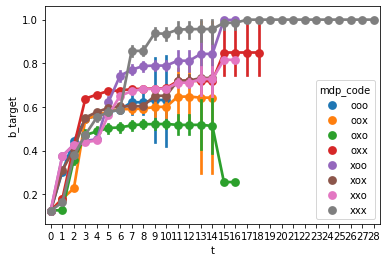

In [8]:
sns.pointplot(data=do_trajdata, x='t', y='b_target', hue='mdp_code')

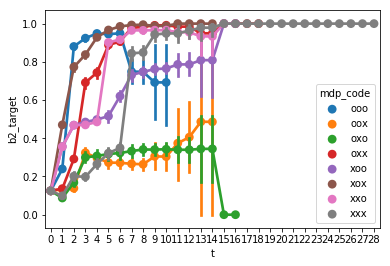

In [11]:
sns.pointplot(data=do_trajdata, x='t', y='b2_target', hue='mdp_code')

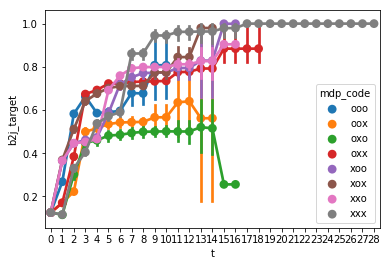

In [12]:
sns.pointplot(data=do_trajdata, x='t', y='b2j_target', hue='mdp_code')

# Generate showing simulations and observer beliefs

In [13]:
np.random.seed(85756)
trajdata = []
for rfc, obp in obplanners.items():
    for traj_i in range(n_trajs):
        traj = obp.run()
        b2tup = ob2_mdp.get_init_state()[0]
        b2jtup = ob2_joint_mdp.get_init_state()[0]
        for t, step in enumerate(traj):
            tdata = step._asdict()
            tdata.update({
                't': t,
                'traj_i': traj_i,
                'mdp_code': rfc,
                'belief-reward': show_reward
            })
            bw = tdata['s']
            nbw = tdata['ns']
            
            #first-order updates
            b = dict(zip(['b.'+c for c in mdp_codes], bw[0]))
            tdata.update(b)
            tdata['s'] = bw[1]
            tdata['b_target'] = b['b.'+rfc]
            
            #second-order updates
            b2 = dict(zip(['b2.'+c for c in mdp_codes], b2tup))
            tdata.update(b2)
            tdata['b2_target'] = b2['b2.'+rfc]
            b2w = (b2tup, bw)
            nb2_dist = ob2_mdp.transition_dist(b2w, tdata['a'])
            nb2tup = next(b2s[0] for b2s in nb2_dist.keys() if b2s[1] == nbw)            
            
            #joint second-order updates
            b2j = dict(zip(['b2j.'+c for c in b2j_order], b2jtup))
            tdata.update(b2j)
            tdata['b2j_target'] = b2j['b2j.'+rfc+'_com'] + b2j['b2j.'+rfc+'_nocom']
            b2jw = (b2jtup, bw)
            nb2j_dist = ob2_joint_mdp.transition_dist(b2jw, tdata['a'])
            nb2jtup = next(b2jw[0] for b2jw in nb2j_dist.keys() if b2jw[1] == nbw)
            
            b2tup = nb2tup
            b2jtup = nb2jtup
            trajdata.append(tdata)
            
show_trajdata = pd.DataFrame(trajdata)

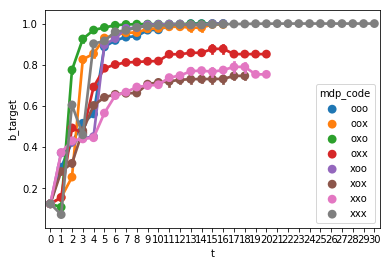

In [14]:
sns.pointplot(data=show_trajdata, x='t', y='b_target', hue='mdp_code')

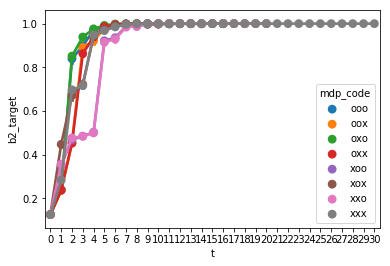

In [15]:
sns.pointplot(data=show_trajdata, x='t', y='b2_target', hue='mdp_code')

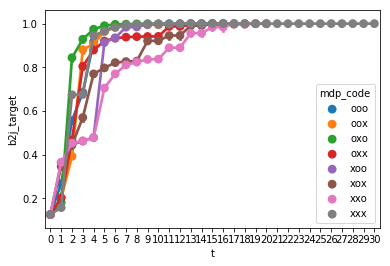

In [16]:
sns.pointplot(data=show_trajdata, x='t', y='b2j_target', hue='mdp_code')

# Output doing and showing simulation results

In [17]:
do_trajdata = do_trajdata.reindex(sorted(do_trajdata.columns), axis=1)
show_trajdata = show_trajdata.reindex(sorted(show_trajdata.columns), axis=1)

trajdata = pd.concat([do_trajdata, show_trajdata])
trajdata.to_pickle("./_comps/sim-trajs.df.pkl")

# Calculate observer beliefs for experiment trajectories

In [18]:
exptrials = pd.read_pickle("./_input/exp1-trials.pd.pkl")
exptrials['state'] = exptrials['stateaction'].apply(lambda sa: sa[0])

In [19]:
def build_traj(rows):
    rows = rows.sort_values('timestep')
    sa = list(rows['stateaction'])
    sans = [(t[0], t[1], nt[0]) for t, nt in zip(sa, sa[1:]+[((5, 2), '%')])]
    return sans
exptrajs = exptrials.groupby(['participant', 'cond', 'phase', 'episode', 'rf']).apply(build_traj)
exptrajs = exptrajs.to_frame("traj").reset_index()

In [20]:
np.random.seed(8575)
exptrajdata = []
for row_i, row in exptrajs.iterrows():
    traj = row['traj']
    is_valid_traj = planners['ooo'].mdp.is_valid_trajectory(traj)
    if not is_valid_traj:
        print("{} {} invalid trajectory".format(row_i, row['phase']))
        continue
    rfc = row['rf']
    btraj = do_traj_belief_trans(traj, rfc, 0, obplanner, ob2_mdp, ob2_joint_mdp)
    for step in btraj:
        step['phase'] = row['phase']
        step['episode'] = row['episode']
        step['cond'] = row['cond']
        step['participant'] = row['participant']
    exptrajdata.extend(btraj)
exptrajdata = pd.DataFrame(exptrajdata)

1272 apply invalid trajectory
1273 apply invalid trajectory
1274 apply invalid trajectory
1275 apply invalid trajectory
1288 learn invalid trajectory
1289 learn invalid trajectory
1290 learn invalid trajectory
1291 learn invalid trajectory


# Output experimental trajectories and (simulated) observer beliefs

In [21]:
exptrajdata.to_pickle("./_comps/exp-trajs-sim-obs.df.pkl")
exptrajdata.to_csv("./_comps/exp-trajs-sim-obs.csv")